In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from math import sqrt

# Global output widget that will hold simulation results.
out = widgets.Output()

def simulate_population_outcome(W_birth, Y_birth, W_death, Y_death,
                                X_size, Z_size, X_rate, Z_rate,
                                Time, use_X, use_Z, grid_points):
    """
    This function computes the upper equilibria for W and Y, then for each W0 (sampled below the equilibrium)
    it uses a binary search in Y0 to determine the switching point between extinction (0) and survival (1).
    A progress bar is shown and, if any slider is changed, previous progress is cleared so that only the current
    slider status is calculated and displayed. Additionally, the current slider values are printed.
    """
    # Clear the output widget so previous progress is removed.
    out.clear_output(wait=True)
    with out:
        # Display current slider values.
        print("Current Slider Values:")
        print(f"  W_birth = {W_birth}, W_death = {W_death}")
        print(f"  Y_birth = {Y_birth}, Y_death = {Y_death}")
        print(f"  X_size  = {X_size}, X_rate  = {X_rate}")
        print(f"  Z_size  = {Z_size}, Z_rate  = {Z_rate}")
        print(f"  Time    = {Time}, Grid Points = {grid_points}")
        print(f"  use_X   = {use_X}, use_Z   = {use_Z}")
        print("\nStarting simulation...\n")
        
        # Compute parameter ratios and discriminants for the equilibria.
        Q1 = W_death / W_birth
        Q2 = Y_death / Y_birth

        disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
        disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1

        if disc_W < 0 or disc_Y < 0:
            print("Invalid parameters: discriminant is negative. Equilibria are not real.")
            return

        # Compute the stable (upper) equilibria for W and Y.
        W_equil = 0.5 * ((1 - Q1 + Q2) + sqrt(disc_W))
        Y_equil = 0.5 * ((1 - Q2 + Q1) + sqrt(disc_Y))
        
        # Define simulation parameters.
        dt = 0.01
        t = np.arange(0, Time + dt, dt)
        extinction_threshold = 0.01  # Population is considered extinct if both W and Y are below this at final time.

        def simulate_once(W0, Y0):
            """
            Simulate the DE system for one set of initial conditions (W0, Y0)
            (with X0 = W0 and Z0 = Y0) and return 0 if the population dies
            (both W and Y fall below the extinction threshold), or 1 otherwise.
            """
            X0, Z0 = W0, Y0
            W = np.zeros_like(t)
            Y = np.zeros_like(t)
            X = np.zeros_like(t)
            Z = np.zeros_like(t)
            W[0], Y[0], X[0], Z[0] = W0, Y0, X0, Z0

            for k in range(1, len(t)):
                dW = -W_birth * W[k - 1]**2 * Y[k - 1] + W_birth * W[k - 1] * Y[k - 1] - W_death * W[k - 1]
                dY = -Y_birth * Y[k - 1]**2 * W[k - 1] + Y_birth * W[k - 1] * Y[k - 1] - Y_death * Y[k - 1]
                if use_X:
                    dW += X_rate * X_size * (X[k - 1] - W[k - 1])
                if use_Z:
                    dY += Z_rate * Z_size * (Z[k - 1] - Y[k - 1])
                dX = X_size * (W[k - 1] - X[k - 1])
                dZ = Z_size * (Y[k - 1] - Z[k - 1])
                
                W[k] = W[k - 1] + dt * dW
                Y[k] = Y[k - 1] + dt * dY
                X[k] = X[k - 1] + dt * dX
                Z[k] = Z[k - 1] + dt * dZ

            return 0 if (W[-1] < extinction_threshold and Y[-1] < extinction_threshold) else 1

        # Create grid of W0 values (columns) and Y0 values (rows) below the respective equilibria.
        W0_vals = np.linspace(0, W_equil, grid_points, endpoint=False)
        Y0_vals = np.linspace(0, Y_equil, grid_points, endpoint=False)
        outcome_grid = np.zeros((grid_points, grid_points))
        
        tol = 1e-3  # Tolerance for binary search in Y0.

        # Create a progress bar.
        progress = widgets.IntProgress(min=0, max=grid_points, description='Progress:')
        display(progress)

        # For each W0, use binary search in Y0 to locate the switching point.
        for i, W0 in enumerate(W0_vals):
            outcome_low = simulate_once(W0, 0.0)
            outcome_high = simulate_once(W0, Y_equil * 0.999)
            
            if outcome_low == 1:
                threshold = 0.0
            elif outcome_high == 0:
                threshold = Y_equil
            else:
                low_val, high_val = 0.0, Y_equil
                while high_val - low_val > tol:
                    mid_val = (low_val + high_val) / 2
                    outcome_mid = simulate_once(W0, mid_val)
                    if outcome_mid == 0:
                        low_val = mid_val
                    else:
                        high_val = mid_val
                threshold = high_val
            
            # For fixed W0, assign outcomes according to the switching threshold.
            for j, Y0 in enumerate(Y0_vals):
                outcome_grid[j, i] = 0 if Y0 < threshold else 1

            progress.value = i + 1  # Update progress bar.
        
        # Plot the outcome grid as a heatmap.
        plt.figure(figsize=(8, 6))
        plt.imshow(outcome_grid, origin='lower',
                   extent=[W0_vals[0], W0_vals[-1], Y0_vals[0], Y0_vals[-1]],
                   aspect='auto', cmap='viridis')
        plt.colorbar(label='Population Outcome (0: Dies, 1: Lives)')
        plt.xlabel('Initial W0')
        plt.ylabel('Initial Y0')
        plt.title('Population Outcome via Binary Search Thresholds')
        plt.show()

# Define widget layouts for each column.
slider_layout = widgets.Layout(width='300px')

# --- Column 1: W Parameters ---
W_birth_slider = widgets.FloatSlider(min=0.01, max=2.0, step=0.01, value=0.4,
                                     description="W_birth", style={'handle_color': 'darkgreen'}, layout=slider_layout)
W_death_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1,
                                     description="W_death", style={'handle_color': 'darkgreen'}, layout=slider_layout)
col1 = widgets.VBox([W_birth_slider, W_death_slider])

# --- Column 2: Y Parameters ---
Y_birth_slider = widgets.FloatSlider(min=0.01, max=2.0, step=0.01, value=0.9,
                                     description="Y_birth", style={'handle_color': 'darkblue'}, layout=slider_layout)
Y_death_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.15,
                                     description="Y_death", style={'handle_color': 'darkblue'}, layout=slider_layout)
col2 = widgets.VBox([Y_birth_slider, Y_death_slider])

# --- Column 3: Coupling Parameters ---
X_size_slider = widgets.FloatSlider(min=0.01, max=10.0, step=0.01, value=0.3,
                                    description="X_size", style={'handle_color': 'lightgreen'}, layout=slider_layout)
X_rate_slider = widgets.FloatSlider(min=0.0, max=2.0, step=0.01, value=0.1,
                                    description="X_rate", style={'handle_color': 'lightgreen'}, layout=slider_layout)
Z_size_slider = widgets.FloatSlider(min=0.01, max=10.0, step=0.01, value=0.2,
                                    description="Z_size", style={'handle_color': 'lightskyblue'}, layout=slider_layout)
Z_rate_slider = widgets.FloatSlider(min=0.0, max=2.0, step=0.01, value=0.05,
                                    description="Z_rate", style={'handle_color': 'lightskyblue'}, layout=slider_layout)
col3 = widgets.VBox([X_size_slider, X_rate_slider, Z_size_slider, Z_rate_slider])

# --- Column 4: Simulation Parameters ---
Time_slider = widgets.IntSlider(min=10, max=1000, step=10, value=100,
                                description="Time", layout=slider_layout)
grid_points_slider = widgets.IntSlider(min=10, max=100, step=1, value=25,
                                       description="Grid Points", layout=slider_layout)
use_X_checkbox = widgets.Checkbox(value=True, description="Enable X", layout=slider_layout)
use_Z_checkbox = widgets.Checkbox(value=True, description="Enable Z", layout=slider_layout)
col4 = widgets.VBox([Time_slider, grid_points_slider, use_X_checkbox, use_Z_checkbox])

# Combine the columns into one control panel.
controls = widgets.HBox([col1, col2, col3, col4])

# Bind the simulation function to the current slider values.
# Using interactive_output here ensures that whenever a slider changes,
# simulate_population_outcome is re-run and the output widget "out" is updated.
interactive_out = widgets.interactive_output(simulate_population_outcome, {
    'W_birth': W_birth_slider, 'Y_birth': Y_birth_slider,
    'W_death': W_death_slider, 'Y_death': Y_death_slider,
    'X_size': X_size_slider, 'Z_size': Z_size_slider,
    'X_rate': X_rate_slider, 'Z_rate': Z_rate_slider,
    'Time': Time_slider,
    'use_X': use_X_checkbox, 'use_Z': use_Z_checkbox,
    'grid_points': grid_points_slider
})

# Display the control panel and the output widget.
display(controls, out)

Output()

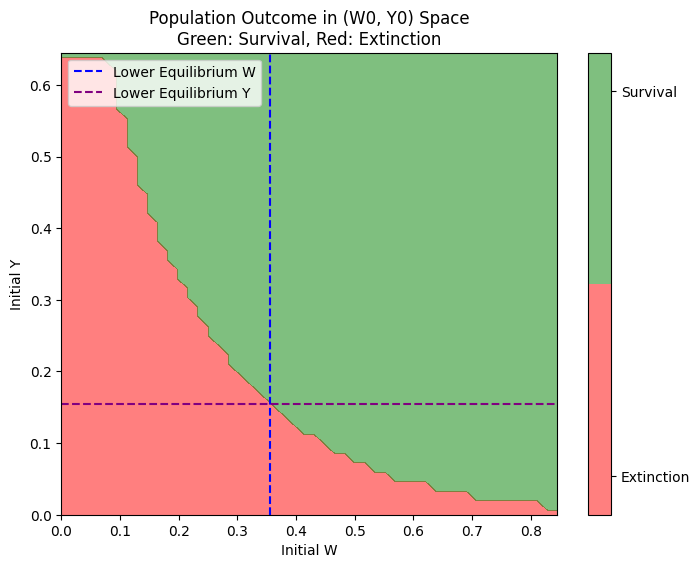

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_population(W0, Y0, X0, Z0, 
                        W_birth, Y_birth, W_death, Y_death,
                        X_size, Z_size, X_rate, Z_rate, 
                        Time, use_X, use_Z, dt=0.01):
    """
    Integrate the differential equations using Euler's method for the given initial conditions.
    The outcome (survival vs. death) is determined by comparing the final state of W to the computed upper equilibrium.
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    # Compute equilibria for W.
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
        lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    else:
        upper_W = np.nan
        lower_W = np.nan

    # Compute equilibria for Y.
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
        lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    else:
        upper_Y = np.nan
        lower_Y = np.nan

    t = np.arange(0, Time + dt, dt)
    W = np.zeros_like(t)
    Y = np.zeros_like(t)
    X = np.zeros_like(t)
    Z = np.zeros_like(t)
    W[0], Y[0], X[0], Z[0] = W0, Y0, X0, Z0

    for i in range(1, len(t)):
        dW = -W_birth * W[i - 1]**2 * Y[i - 1] + W_birth * W[i - 1] * Y[i - 1] - W_death * W[i - 1]
        dY = -Y_birth * Y[i - 1]**2 * W[i - 1] + Y_birth * W[i - 1] * Y[i - 1] - Y_death * Y[i - 1]
        if use_X:
            dW += X_rate * X_size * (X[i - 1] - W[i - 1])
        if use_Z:
            dY += Z_rate * Z_size * (Z[i - 1] - Y[i - 1])
        dX = X_rate * (W[i - 1] - X[i - 1])
        dZ = Z_rate * (Y[i - 1] - Z[i - 1])
        
        W[i] = W[i - 1] + dt * dW
        Y[i] = Y[i - 1] + dt * dY
        X[i] = X[i - 1] + dt * dX
        Z[i] = Z[i - 1] + dt * dZ

    # Decision criterion: if final W is closer to the upper equilibrium than to zero, classify as survival.
    return np.abs(W[-1] - upper_W) < np.abs(W[-1] - 0)

def find_critical_Y(W0, X0, Z0, lower_Y, upper_Y, 
                    W_birth, Y_birth, W_death, Y_death,
                    X_size, Z_size, X_rate, Z_rate, 
                    Time, use_X, use_Z, tol=1e-3, max_iter=20):
    """
    For a fixed W0, find the unique switching value Y0* (via binary search) such that:
      - For Y0 < Y0*, the simulation results in extinction.
      - For Y0 >= Y0*, the simulation yields survival.
    The search is performed over the interval [0, upper_Y].
    """
    # Check endpoints.
    outcome_low = simulate_population(W0, 0, X0, Z0,
                                      W_birth, Y_birth, W_death, Y_death,
                                      X_size, Z_size, X_rate, Z_rate,
                                      Time, use_X, use_Z)
    outcome_high = simulate_population(W0, upper_Y, X0, Z0,
                                       W_birth, Y_birth, W_death, Y_death,
                                       X_size, Z_size, X_rate, Z_rate,
                                       Time, use_X, use_Z)
    if outcome_low:
        return 0.0
    if not outcome_high:
        return upper_Y

    low_bound = 0.0
    high_bound = upper_Y

    for _ in range(max_iter):
        mid = (low_bound + high_bound) / 2.0
        outcome_mid = simulate_population(W0, mid, X0, Z0,
                                          W_birth, Y_birth, W_death, Y_death,
                                          X_size, Z_size, X_rate, Z_rate,
                                          Time, use_X, use_Z)
        if outcome_mid:
            high_bound = mid
        else:
            low_bound = mid
        if high_bound - low_bound < tol:
            break
    return high_bound

def analyze_switching(W_birth, Y_birth, W_death, Y_death,
                      X_size, Z_size, X_rate, Z_rate, 
                      Time, use_X, use_Z, n_points=50):
    """
    Analyze the switching behavior in the (W0, Y0) plane.
    
    The function first checks that both W and Y equilibria exist.
    For each fixed W0, it uses binary search to determine the unique critical Y0 value that
    separates extinction from survival. A contour plot is generated showing regions of survival (green)
    and extinction (red), with dashed lines indicating the lower equilibria.
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    
    # Compute equilibria for W.
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        print("Equilibria for W do not exist. Aborting analysis.")
        return
    sqrt_disc_W = np.sqrt(disc_W)
    upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    
    # Compute equilibria for Y.
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        print("Equilibria for Y do not exist. Aborting analysis.")
        return
    sqrt_disc_Y = np.sqrt(disc_Y)
    upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    
    # Create array of W0 values.
    W0_values = np.linspace(0, upper_W, n_points)
    critical_Y_vals = np.zeros_like(W0_values)
    # Fixed initial conditions for X and Z are set relative to the computed upper equilibria.
    X0 = upper_W
    Z0 = upper_Y

    # For each fixed W0, use binary search to determine the switching threshold in Y.
    for idx, W0 in enumerate(W0_values):
        critical_Y_vals[idx] = find_critical_Y(W0, X0, Z0, lower_Y, upper_Y,
                                               W_birth, Y_birth, W_death, Y_death,
                                               X_size, Z_size, X_rate, Z_rate,
                                               Time, use_X, use_Z)

    # Build the outcome matrix from the computed critical thresholds.
    Y0_values = np.linspace(0, upper_Y, n_points)
    outcome = np.zeros((n_points, n_points))
    for i, W0 in enumerate(W0_values):
        for j, Y0 in enumerate(Y0_values):
            # Outcome is survival if Y0 is above the threshold for this W0.
            outcome[j, i] = 1 if Y0 >= critical_Y_vals[i] else 0

    # Plot the outcome in the (W0, Y0) plane.
    plt.figure(figsize=(8, 6))
    W0_mesh, Y0_mesh = np.meshgrid(W0_values, Y0_values)
    plt.contourf(W0_mesh, Y0_mesh, outcome, levels=[-0.1, 0.5, 1.1], colors=['red', 'green'], alpha=0.5)
    
    plt.xlabel('Initial W')
    plt.ylabel('Initial Y')
    plt.title('Population Outcome in (W0, Y0) Space\nGreen: Survival, Red: Extinction')
    cbar = plt.colorbar(ticks=[0, 1])
    cbar.ax.set_yticklabels(['Extinction', 'Survival'])
    
    # Add dashed lines for the lower equilibria.
    plt.axvline(x=lower_W, color='blue', linestyle='--', label='Lower Equilibrium W')
    plt.axhline(y=lower_Y, color='purple', linestyle='--', label='Lower Equilibrium Y')
    
    plt.xlim(0, upper_W)
    plt.ylim(0, upper_Y)
    plt.legend(loc='upper left')
    plt.show()

# Example usage with sample parameter values.
W_birth = 1.0
Y_birth = 1.0
W_death = 0.1
Y_death = 0.3
X_size = 0.5
Z_size = 0.5
X_rate = 0.2
Z_rate = 0.2
Time = 50
use_X = False
use_Z = False

analyze_switching(W_birth, Y_birth, W_death, Y_death, 
                  X_size, Z_size, X_rate, Z_rate, 
                  Time, use_X, use_Z, n_points=50)

/var/folders/57/ffrpkhfx7xq73dykhyvrqgw40000gn/T/ipykernel_9343/4215350728.py:181: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, num_lines))


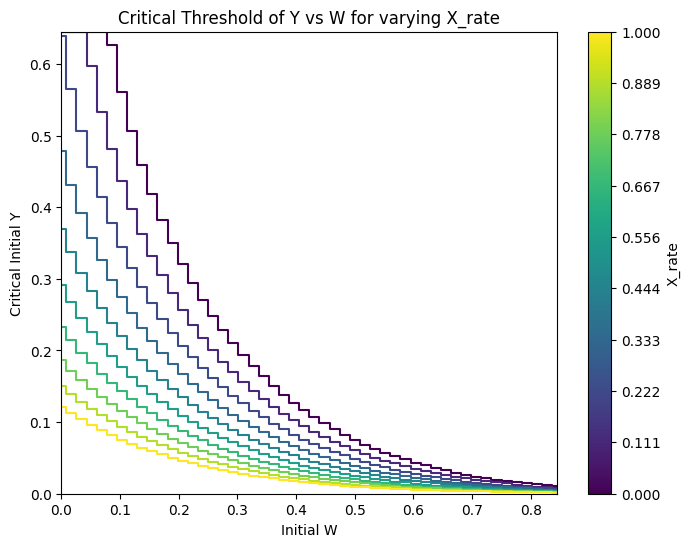

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def simulate_population(W0, Y0, X0, Z0, 
                        W_birth, Y_birth, W_death, Y_death,
                        X_size, Z_size, X_rate, Z_rate, 
                        Time, use_X, use_Z, dt=0.01):
    """
    Integrate the differential equations using Euler's method for the given initial conditions.
    The outcome (survival vs. extinction) is determined by comparing the final state of W with the computed upper equilibrium.
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    # Compute equilibria for W.
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
        lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    else:
        upper_W = np.nan
        lower_W = np.nan

    # Compute equilibria for Y.
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
        lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    else:
        upper_Y = np.nan
        lower_Y = np.nan

    t = np.arange(0, Time + dt, dt)
    W = np.zeros_like(t)
    Y = np.zeros_like(t)
    X = np.zeros_like(t)
    Z = np.zeros_like(t)
    W[0], Y[0], X[0], Z[0] = W0, Y0, X0, Z0

    for i in range(1, len(t)):
        dW = -W_birth * W[i - 1]**2 * Y[i - 1] + W_birth * W[i - 1] * Y[i - 1] - W_death * W[i - 1]
        dY = -Y_birth * Y[i - 1]**2 * W[i - 1] + Y_birth * W[i - 1] * Y[i - 1] - Y_death * Y[i - 1]
        if use_X:
            dW += X_rate * X_size * (X[i - 1] - W[i - 1])
        if use_Z:
            dY += Z_rate * Z_size * (Z[i - 1] - Y[i - 1])
        dX = X_size * (W[i - 1] - X[i - 1])
        dZ = Z_size * (Y[i - 1] - Z[i - 1])
        
        W[i] = W[i - 1] + dt * dW
        Y[i] = Y[i - 1] + dt * dY
        X[i] = X[i - 1] + dt * dX
        Z[i] = Z[i - 1] + dt * dZ

    # Outcome: survival if final W is closer to the upper equilibrium than to zero.
    return np.abs(W[-1] - upper_W) < np.abs(W[-1] - 0)

def find_critical_Y(W0, X0, Z0, lower_Y, upper_Y, 
                    W_birth, Y_birth, W_death, Y_death,
                    X_size, Z_size, X_rate, Z_rate, 
                    Time, use_X, use_Z, tol=1e-3, max_iter=20):
    """
    For a fixed W0, find the unique switching value Y0* (via binary search) such that:
      - For Y0 < Y0*, the simulation results in extinction.
      - For Y0 >= Y0*, the simulation yields survival.
    The search is performed over the interval [0, upper_Y].
    """
    outcome_low = simulate_population(W0, 0, X0, Z0,
                                      W_birth, Y_birth, W_death, Y_death,
                                      X_size, Z_size, X_rate, Z_rate,
                                      Time, use_X, use_Z)
    outcome_high = simulate_population(W0, upper_Y, X0, Z0,
                                       W_birth, Y_birth, W_death, Y_death,
                                       X_size, Z_size, X_rate, Z_rate,
                                       Time, use_X, use_Z)
    if outcome_low:
        return 0.0
    if not outcome_high:
        return upper_Y

    low_bound = 0.0
    high_bound = upper_Y

    for _ in range(max_iter):
        mid = (low_bound + high_bound) / 2.0
        outcome_mid = simulate_population(W0, mid, X0, Z0,
                                          W_birth, Y_birth, W_death, Y_death,
                                          X_size, Z_size, X_rate, Z_rate,
                                          Time, use_X, use_Z)
        if outcome_mid:
            high_bound = mid
        else:
            low_bound = mid
        if high_bound - low_bound < tol:
            break
    return high_bound

def analyze_threshold_lines(active='X', num_lines=10, n_points=50, 
                            W_birth=1.0, Y_birth=1.0, W_death=0.3, Y_death=0.3,
                            X_size=0.5, Z_size=0.5, Time=50, dt=0.01, tol=1e-3, max_iter=20):
    """
    For the chosen auxiliary variable (active = 'X' or 'Z'), this routine computes
    and plots multiple threshold lines. For each value of the rate parameter (X_rate or Z_rate)
    ranging from 0 to 1, the function computes the critical initial Y threshold (via binary search)
    for a range of W0 values. The threshold line is plotted as an orthogonal step function.
    
    The lines are colored using a heatmap (here using the viridis colormap) to indicate the rate value.
    """
    # Compute the reaction equilibria (independent of X_rate and Z_rate)
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        print("Equilibria for W do not exist. Aborting analysis.")
        return
    sqrt_disc_W = np.sqrt(disc_W)
    upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        print("Equilibria for Y do not exist. Aborting analysis.")
        return
    sqrt_disc_Y = np.sqrt(disc_Y)
    upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    
    # Define grid for initial W values.
    W0_values = np.linspace(0, upper_W, n_points)
    
    # Create the array of rate values (for either X_rate or Z_rate) from 0 to 1.
    rate_values = np.linspace(0, 1, num_lines)
    
    # Choose colormap.
    colormap = cm.viridis
    
    # Fixed initial conditions for X and Z (relative to the upper equilibria).
    X0 = upper_W
    Z0 = upper_Y

    plt.figure(figsize=(8,6))
    
    # Loop over the different rate values.
    for i, rate in enumerate(rate_values):
        if active.upper() == 'X':
            use_X = True
            use_Z = False
            X_rate = rate
            Z_rate = 0.0
        elif active.upper() == 'Z':
            use_X = False
            use_Z = True
            X_rate = 0.0
            Z_rate = rate
        else:
            raise ValueError("Active parameter must be 'X' or 'Z'")
        
        # Compute the threshold line (critical Y for each W0) for this rate.
        threshold_line = np.zeros_like(W0_values)
        for idx, W0 in enumerate(W0_values):
            threshold_line[idx] = find_critical_Y(W0, X0, Z0, lower_Y, upper_Y,
                                                  W_birth, Y_birth, W_death, Y_death,
                                                  X_size, Z_size, X_rate, Z_rate,
                                                  Time, use_X, use_Z, tol=tol, max_iter=max_iter)
        # Plot as an orthogonal step function.
        plt.step(W0_values, threshold_line, where='mid', 
                 color=colormap(rate), label=f'{active}_rate = {rate:.2f}')
    
    plt.xlabel('Initial W')
    plt.ylabel('Critical Initial Y')
    plt.title(f'Critical Threshold of Y vs W for varying {active}_rate')
    plt.xlim(0, upper_W)
    plt.ylim(0, upper_Y)
    
    # Use a ScalarMappable to create a colorbar mapping rate values.
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, num_lines))
    cbar.set_label(f'{active}_rate')
    
    plt.show()

# Example usage:
# To analyze the influence of X_rate (with only X active):
analyze_threshold_lines(active='X', num_lines=10, n_points=50,
                        W_birth=1.0, Y_birth=1.0, W_death=0.1, Y_death=0.3,
                        X_size=0.5, Z_size=0.5, Time=50)

# To analyze the influence of Z_rate (with only Z active), simply change the active parameter:
# analyze_threshold_lines(active='Z', num_lines=10, n_points=50, 
#                         W_birth=1.0, Y_birth=1.0, W_death=0.3, Y_death=0.3,
#                         X_size=0.5, Z_size=0.5, Time=50)

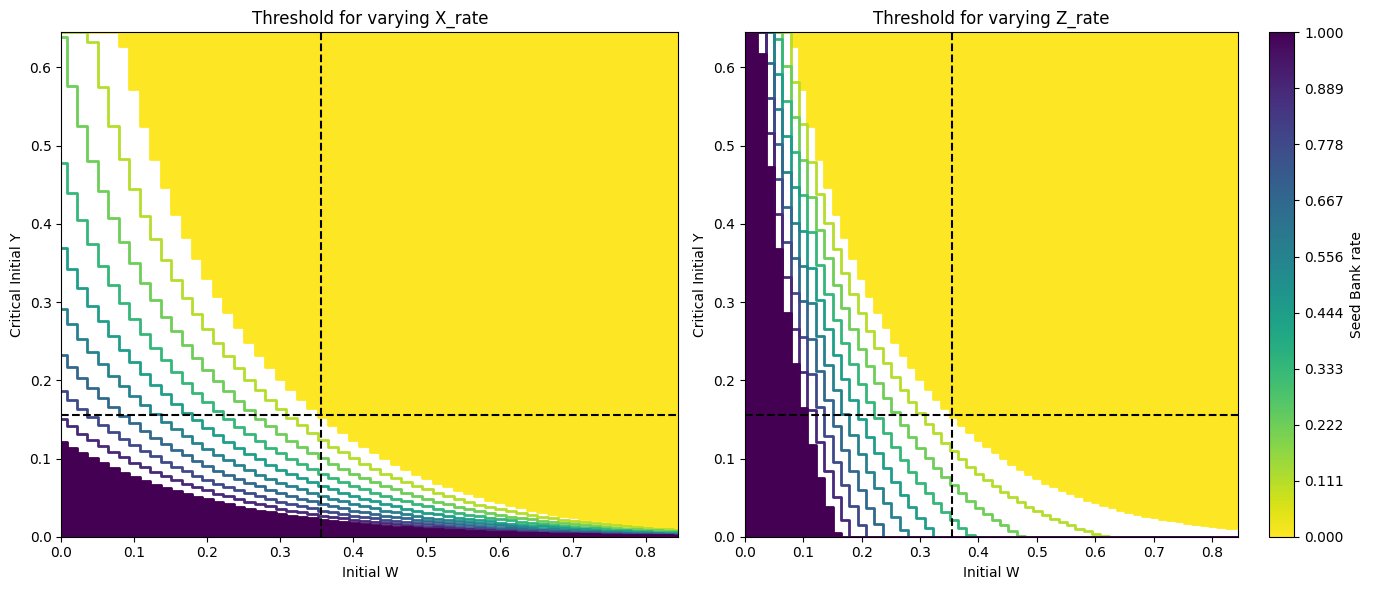

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_population(W0, Y0, X0, Z0, 
                        W_birth, Y_birth, W_death, Y_death,
                        X_size, Z_size, X_rate, Z_rate, 
                        Time, use_X, use_Z, dt=0.01):
    """
    Integrate the differential equations using Euler's method.
    The outcome (survival vs. extinction) is determined by comparing the final value of W 
    to the computed upper equilibrium.
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    # Compute equilibria for W.
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
        lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    else:
        upper_W = np.nan
        lower_W = np.nan

    # Compute equilibria for Y.
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
        lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    else:
        upper_Y = np.nan
        lower_Y = np.nan

    t = np.arange(0, Time + dt, dt)
    W = np.zeros_like(t)
    Y = np.zeros_like(t)
    X = np.zeros_like(t)
    Z = np.zeros_like(t)
    W[0], Y[0], X[0], Z[0] = W0, Y0, X0, Z0

    for i in range(1, len(t)):
        dW = -W_birth * W[i - 1]**2 * Y[i - 1] + W_birth * W[i - 1] * Y[i - 1] - W_death * W[i - 1]
        dY = -Y_birth * Y[i - 1]**2 * W[i - 1] + Y_birth * W[i - 1] * Y[i - 1] - Y_death * Y[i - 1]
        if use_X:
            dW += X_rate * X_size * (X[i - 1] - W[i - 1])
        if use_Z:
            dY += Z_rate * Z_size * (Z[i - 1] - Y[i - 1])
        dX = X_size * (W[i - 1] - X[i - 1])
        dZ = Z_size * (Y[i - 1] - Z[i - 1])
        
        W[i] = W[i - 1] + dt * dW
        Y[i] = Y[i - 1] + dt * dY
        X[i] = X[i - 1] + dt * dX
        Z[i] = Z[i - 1] + dt * dZ

    # Outcome: survival if final W is closer to the upper equilibrium than to zero.
    return np.abs(W[-1] - upper_W) < np.abs(W[-1] - 0)

def find_critical_Y(W0, X0, Z0, lower_Y, upper_Y, 
                    W_birth, Y_birth, W_death, Y_death,
                    X_size, Z_size, X_rate, Z_rate, 
                    Time, use_X, use_Z, tol=1e-3, max_iter=20):
    """
    For a fixed W0, find the unique switching value Y0* (via binary search) such that:
      - For Y0 < Y0*, the simulation yields extinction.
      - For Y0 >= Y0*, it yields survival.
    The search is performed over [0, upper_Y].
    """
    outcome_low = simulate_population(W0, 0, X0, Z0,
                                      W_birth, Y_birth, W_death, Y_death,
                                      X_size, Z_size, X_rate, Z_rate,
                                      Time, use_X, use_Z)
    outcome_high = simulate_population(W0, upper_Y, X0, Z0,
                                       W_birth, Y_birth, W_death, Y_death,
                                       X_size, Z_size, X_rate, Z_rate,
                                       Time, use_X, use_Z)
    if outcome_low:
        return 0.0
    if not outcome_high:
        return upper_Y

    low_bound = 0.0
    high_bound = upper_Y

    for _ in range(max_iter):
        mid = (low_bound + high_bound) / 2.0
        outcome_mid = simulate_population(W0, mid, X0, Z0,
                                          W_birth, Y_birth, W_death, Y_death,
                                          X_size, Z_size, X_rate, Z_rate,
                                          Time, use_X, use_Z)
        if outcome_mid:
            high_bound = mid
        else:
            low_bound = mid
        if high_bound - low_bound < tol:
            break
    return high_bound

def plot_threshold_lines(ax, active='X', num_lines=10, n_points=50, 
                         W_birth=1.0, Y_birth=1.0, W_death=0.3, Y_death=0.3,
                         X_size=0.5, Z_size=0.5, Time=50, dt=0.01, tol=1e-3, max_iter=20):
    """
    On the given axis, plot the threshold lines (critical initial Y vs. W0) 
    as the auxiliary rate (either X_rate or Z_rate) varies from 0 to 1.
    
    The threshold lines are drawn as step functions and colored using the viridis colormap.
    Only the region above the threshold line for rate 0 and below the threshold line for rate 1 is filled.
    The lower equilibrium lines (vertical and horizontal) are drawn in black.
    """
    # Reaction equilibria (independent of the auxiliary rate).
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth
    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        print("Equilibria for W do not exist. Aborting analysis.")
        return
    sqrt_disc_W = np.sqrt(disc_W)
    upper_W = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    lower_W = 0.5 * ((1 - Q1 + Q2) - sqrt_disc_W)
    
    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        print("Equilibria for Y do not exist. Aborting analysis.")
        return
    sqrt_disc_Y = np.sqrt(disc_Y)
    upper_Y = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    lower_Y = 0.5 * ((1 - Q2 + Q1) - sqrt_disc_Y)
    
    # Grid for initial W values.
    W0_values = np.linspace(0, upper_W, n_points)
    
    # Array of rate values from 0 to 1.
    rate_values = np.linspace(0, 1, num_lines)
    
    # Use the viridis colormap.
    cmap = cmap = plt.cm.viridis_r

    
    # Fixed initial conditions for X and Z (relative to the upper equilibria).
    X0 = upper_W
    Z0 = upper_Y
    
    # Compute threshold lines for each rate value.
    threshold_lines = []
    for rate in rate_values:
        if active.upper() == 'X':
            use_X = True
            use_Z = False
            X_rate = rate
            Z_rate = 0.0
        elif active.upper() == 'Z':
            use_X = False
            use_Z = True
            X_rate = 0.0
            Z_rate = rate
        else:
            raise ValueError("Active parameter must be 'X' or 'Z'")
        
        thresh_line = np.zeros_like(W0_values)
        for idx, W0 in enumerate(W0_values):
            thresh_line[idx] = find_critical_Y(W0, X0, Z0, lower_Y, upper_Y,
                                               W_birth, Y_birth, W_death, Y_death,
                                               X_size, Z_size, X_rate, Z_rate,
                                               Time, use_X, use_Z, tol=tol, max_iter=max_iter)
        threshold_lines.append(thresh_line)
    
    # Invert the fill: since the threshold line for rate 0 is above that for rate 1,
    # fill the region above the threshold line for rate 0 (with color for 0)
    # and below the threshold line for rate 1 (with color for 1).
    ax.fill_between(W0_values, threshold_lines[0], upper_Y,
                    step='mid', color=cmap(rate_values[0]), alpha=1.0)
    ax.fill_between(W0_values, 0, threshold_lines[-1],
                    step='mid', color=cmap(rate_values[-1]), alpha=1.0)
    
    # Plot each threshold line as a step function with its viridis color.
    for i, rate in enumerate(rate_values):
        ax.step(W0_values, threshold_lines[i], where='mid', color=cmap(rate), linewidth=2)
    
    # Draw lower equilibrium lines in black.
    ax.axvline(x=lower_W, color='black', linestyle='--', linewidth=1.5, label='Lower Equilibrium W')
    ax.axhline(y=lower_Y, color='black', linestyle='--', linewidth=1.5, label='Lower Equilibrium Y')
    
    # Set labels and title.
    ax.set_xlabel(r' W_0')
    ax.set_ylabel( r'Y_0')
    if active.upper() == 'X':
        ax.set_title('Threshold for varying X_rate')
    else:
        ax.set_title('Threshold for varying Z_rate')
    ax.set_xlim(0, upper_W)
    ax.set_ylim(0, upper_Y)
    if active == 'Z':
          # Add colorbar for this axis.
        from matplotlib.cm import ScalarMappable
        sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(0, 1, num_lines))
        cbar.set_label(f'Seed Bank rate')
        

# Create a figure with two subplots side-by-side.
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for X_rate.
plot_threshold_lines(axs[0], active='X', num_lines=20, n_points=50,
                       W_birth=1.0, Y_birth=1.0, W_death=0.1, Y_death=0.3,
                       X_size=0.5, Z_size=0.5, Time=50)

# Plot for Z_rate.
plot_threshold_lines(axs[1], active='Z', num_lines=20, n_points=50,
                       W_birth=1.0, Y_birth=1.0, W_death=0.1, Y_death=0.3,
                       X_size=0.5, Z_size=0.5, Time=50)

plt.tight_layout()
plt.savefig('threshold_lines.pdf', dpi=300)
plt.show()